In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 39.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 3.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.2.0
    Uninstalling torch-2.2.0:
      Successfully uninstalled torch-2.2.0


In [2]:
from torchvision.transforms import ToTensor

In [4]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 49.2 MB/s eta 0:00:0000:0100:01


In [3]:
file_name = 'World_Atlas_2015.tif'

In [4]:
import rasterio

src = rasterio.open(file_name)

In [5]:
with rasterio.open('World_Atlas_2015.tif') as image:
    image_array = image.read()

In [6]:
torch_image = ToTensor()(image_array)
print(torch_image.shape)

torch.Size([43200, 1, 17406])


In [7]:
imag = torch_image.permute(1,2,0).numpy()[0]


In [8]:
imag.shape

(17406, 43200)

In [9]:
#plt.imshow(np.log(imag[:17406/2, :17406/2]))

/tmp/ipykernel_3811/3850219427.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(imag[0:16000, 0:20000]))


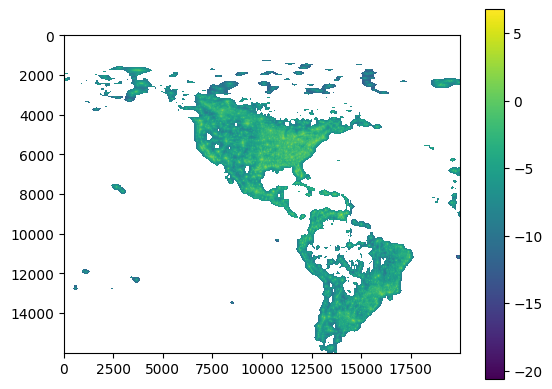

In [10]:
plt.imshow(np.log(imag[0:16000, 0:20000]))
plt.colorbar()

In [11]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the image to access its metadata
with rasterio.open('World_Atlas_2015.tif') as image:
    # Extract the transformation and use it to compute the geographical coordinates
    transform = image.transform
    # Define the pixel range you are interested in
    x_pixels_min, y_pixels_min = 0, 0  # Start corner
    x_pixels_max, y_pixels_max = 20000, 16000  # End corner adjusted based on your subset
    
    # Convert pixel coordinates to geographical coordinates
    lon_min, lat_max = transform * (x_pixels_min, y_pixels_min)
    lon_max, lat_min = transform * (x_pixels_max, y_pixels_max)


/tmp/ipykernel_3811/4289597481.py:6: RuntimeWarning: divide by zero encountered in log
  imag_log = np.log(imag[0:y_pixels_max, 0:x_pixels_max])


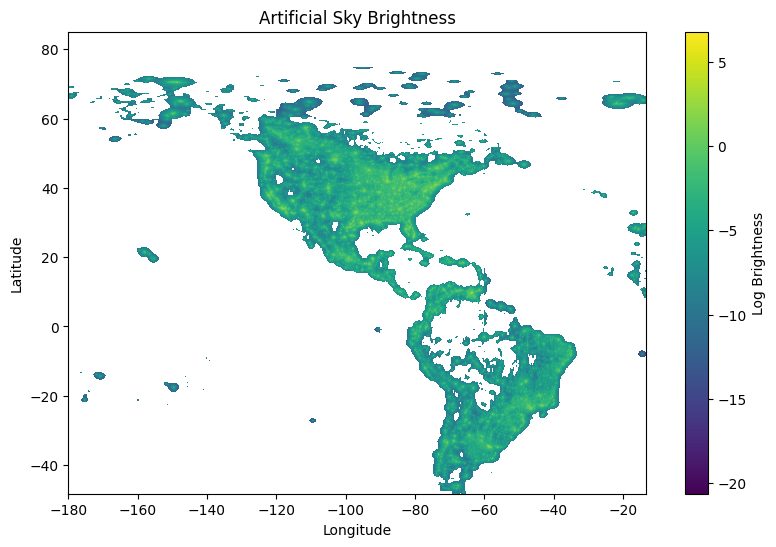

In [14]:
# Ensure imag is prepared as before, focusing on the subset of interest
# This assumes 'imag' has been defined as shown previously
# If imag is not defined here, ensure it is computed before this code

# Log transformation and masking of zeros to avoid log(0)
imag_log = np.log(imag[0:y_pixels_max, 0:x_pixels_max])
imag_log = np.ma.masked_invalid(imag_log)  # Mask invalid values

# Plot the data with geographic coordinates
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.imshow(imag_log, extent=[lon_min, lon_max, lat_min, lat_max], origin='upper')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Artificial Sky Brightness')
fig.colorbar(cax, ax=ax, label='Log Brightness')

plt.show()


In [12]:
import rasterio

# Open the raster file
with rasterio.open('World_Atlas_2015.tif') as src:
    # Get the affine transformation matrix
    transform = src.transform
    
    # The pixel resolution (size) in geographic units
    lon_res = transform.a  # Longitude resolution (degrees per pixel)
    lat_res = abs(transform.e)  # Latitude resolution (degrees per pixel), absolute value
    
    print(f"Longitude resolution: {lon_res} degrees per pixel")
    print(f"Latitude resolution: {lat_res} degrees per pixel")


Longitude resolution: 0.008333330000000002 degrees per pixel
Latitude resolution: 0.008333330000000002 degrees per pixel


In [18]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming imag_log and geographic bounds (lon_min, lon_max, lat_min, lat_max) are defined
# # Define your sampling step for both latitude and longitude to reduce data size
# step_lat = 100  # Adjust these steps based on the resolution you desire
# step_lon = 100

# # Generate latitude and longitude arrays for the sampled points
# lats = np.linspace(lat_min, lat_max, imag_log.shape[0])[::step_lat]
# lons = np.linspace(lon_min, lon_max, imag_log.shape[1])[::step_lon]

# # Create meshgrid for longitude and latitude
# lon_grid, lat_grid = np.meshgrid(lons, lats)

# # Sample imag_log accordingly
# sampled_values = imag_log[::step_lat, ::step_lon]

# # Flatten arrays for plotting
# lon_flat = lon_grid.flatten()
# lat_flat = lat_grid.flatten()
# values_flat = sampled_values.flatten()

# # Convert longitude and latitude to radians for the Aitoff projection
# lon_rad = np.radians(lon_flat)
# lat_rad = np.radians(lat_flat)

# # Plotting
# plt.figure(figsize=(10, 5))
# plt.subplot(111, projection='aitoff')
# plt.imshow(imag_log, extent=[lon_min, lon_max, lat_min, lat_max], origin='upper')
# plt.set_xlabel('Longitude')
# plt.set_ylabel('Latitude')
# plt.set_title('Artificial Sky Brightness')
# plt.colorbar(cax, ax=ax, label='Log Brightness')


# plt.show()


In [ ]:
# Ensure imag is prepared as before, focusing on the subset of interest
# This assumes 'imag' has been defined as shown previously
# If imag is not defined here, ensure it is computed before this code

# Log transformation and masking of zeros to avoid log(0)
imag_log = np.log(imag[0:y_pixels_max, 0:x_pixels_max])
imag_log = np.ma.masked_invalid(imag_log)  # Mask invalid values

plt.figure(figsize=(10, 5))
plt.subplot(111, projection='aitoff')
plt.title("Aitoff Projection of Artificial Sky Brightness")
plt.grid(True)

# Scatter plot on Aitoff projection, coloring by log brightness values
# Mask invalid values to avoid plotting errors
masked_values = np.ma.masked_invalid(values_flat)
plt.scatter(lon_rad, lat_rad, c=masked_values, cmap='viridis', alpha=0.5, s = 2)

plt.colorbar(label='Log Brightness')
plt.show()


cax = ax.imshow(imag_log, extent=[lon_min, lon_max, lat_min, lat_max], origin='upper')
plt.scatter(imag_log)

fig.colorbar(cax, ax=ax, label='Log Brightness')

plt.show()


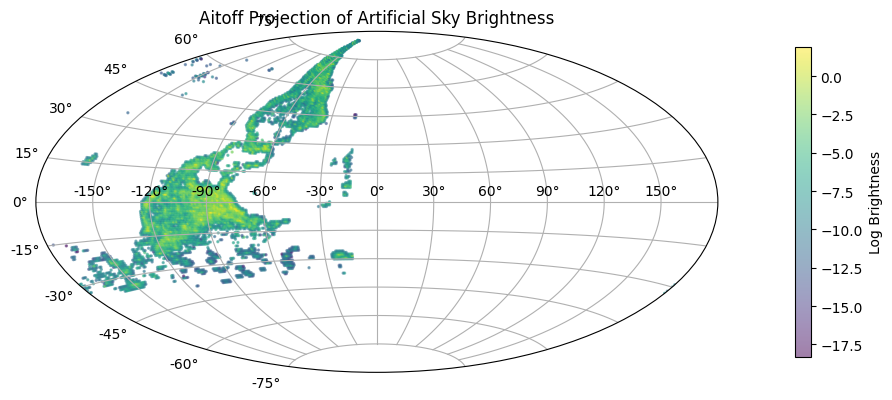

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming imag_log and geographic bounds (lon_min, lon_max, lat_min, lat_max) are defined
# And assuming imag_log, lat_min, lat_max, lon_min, lon_max are already correctly defined

# Define your sampling step for both latitude and longitude to reduce data size
step_lat = 100  # Adjust these steps based on the resolution you desire
step_lon = 100

# Generate latitude and longitude arrays for the sampled points
lats = np.linspace(lat_min, lat_max, imag_log.shape[0])[::step_lat]
lons = np.linspace(lon_min, lon_max, imag_log.shape[1])[::step_lon]

# Create meshgrid for longitude and latitude
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Sample imag_log accordingly
sampled_values = imag_log[::step_lat, ::step_lon]

# Flatten arrays for plotting
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()
values_flat = sampled_values.flatten()

# Convert longitude and latitude to radians for the Aitoff projection
lon_rad = np.radians(lon_flat)
lat_rad = np.radians(lat_flat)

# Adjust longitude for Aitoff projection: convert from [0, 2π] to [-π, π]
lon_rad_adjusted = np.mod(lon_rad + np.pi, 2 * np.pi) - np.pi

# Plotting
plt.figure(figsize=(10, 5))
ax = plt.subplot(111, projection='aitoff')
plt.title("Aitoff Projection of Artificial Sky Brightness")
plt.grid(True)

# Scatter plot on Aitoff projection, coloring by log brightness values
# Mask invalid values to avoid plotting errors
masked_values = np.ma.masked_invalid(values_flat)
sc = ax.scatter(lon_rad_adjusted, lat_rad, c=masked_values, cmap='viridis', alpha=0.5, s=2)

# Adding a colorbar
cbar = plt.colorbar(sc, orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label('Log Brightness')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming imag_log and geographic bounds (lon_min, lon_max, lat_min, lat_max) are defined
# Define your sampling step for both latitude and longitude to reduce data size
step_lat = 100  # Adjust these steps based on the resolution you desire
step_lon = 100

# Generate latitude and longitude arrays for the sampled points
lats = np.linspace(lat_min, lat_max, imag_log.shape[0])[::step_lat]
lons = np.linspace(lon_min, lon_max, imag_log.shape[1])[::step_lon]

# Create meshgrid for longitude and latitude
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Sample imag_log accordingly
sampled_values = imag_log[::step_lat, ::step_lon]

# Flatten arrays for plotting
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()
values_flat = sampled_values.flatten()

# Convert longitude and latitude to radians for the Aitoff projection
lon_rad = np.radians(lon_flat)
lat_rad = np.radians(lat_flat)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(111, projection='aitoff')
plt.title("Aitoff Projection of Artificial Sky Brightness")
plt.grid(True)

# Scatter plot on Aitoff projection, coloring by log brightness values
# Mask invalid values to avoid plotting errors
masked_values = np.ma.masked_invalid(values_flat)
plt.scatter(lon_rad, lat_rad, c=masked_values, cmap='viridis', alpha=0.5, s = 2)

plt.colorbar(label='Log Brightness')
plt.show()


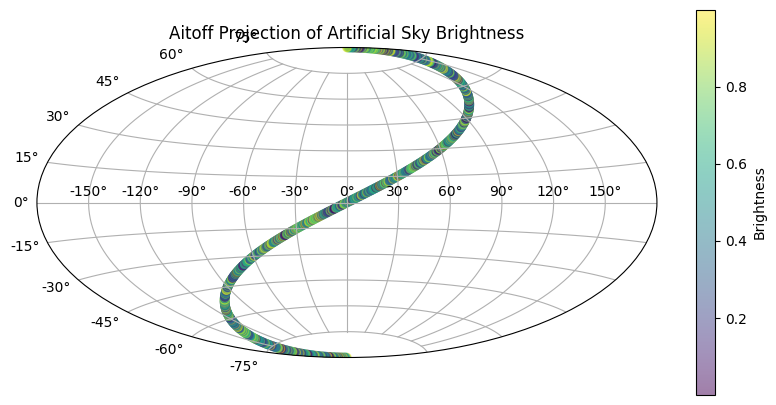

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have latitude and longitude arrays for your data points
# and a corresponding brightness array for those points
# For demonstration, we'll create some dummy data
num_points = 1000
lons = np.linspace(-180, 180, num_points)
lats = np.linspace(-90, 90, num_points)
brightness = np.random.rand(num_points)  # Dummy brightness values

# Convert longitude and latitude to radians for the plot
lons_rad = np.radians(lons)
lats_rad = np.radians(lats)

# Adjust longitude for Aitoff projection: convert from [0, 2π] to [-π, π]
lons_rad_plot = np.mod(lons_rad + np.pi, 2 * np.pi) - np.pi

# Convert latitude for Aitoff projection
# Latitude ranges from [-π/2, π/2] already, so no change needed for co-latitude

# Prepare the brightness values for plotting (e.g., scaling, normalization)
# Here we'll simply use the brightness as-is, assuming it's suitable for direct plotting
brightness_plot = brightness  # Placeholder for any actual preparation

# Set up the plot with Aitoff projection
plt.figure(figsize=(10, 5))
plt.subplot(111, projection='aitoff')
plt.title("Aitoff Projection of Artificial Sky Brightness")
plt.grid(True)

# Scatter plot on Aitoff projection
# Using brightness for color coding
plt.scatter(lons_rad_plot, lats_rad, c=brightness_plot, cmap='viridis', alpha=0.5)

# Colorbar
plt.colorbar(label='Brightness')

# Show plot
plt.show()


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from torchvision.transforms import ToTensor

# Open the TIFF file
with rasterio.open('World_Atlas_2015.tif') as image:
    # Read the image data
    image_array = image.read(1)  # Reading just one band
    
    # Convert to a PyTorch tensor and then back to numpy for plotting
    torch_image = ToTensor()(image_array).numpy()
    
    # Get the affine transformation
    transform = image.transform
    
    # Convert the pixel coordinates of the corners to geographic coordinates
    # Bottom-left corner (min x, min y)
    min_x, min_y = transform * (0, image.height)
    # Top-right corner (max x, max y)
    max_x, max_y = transform * (image.width, 0)

# Use logarithmic scaling to enhance visualization
log_image = np.log(torch_image)

# Plotting
plt.figure(figsize=(10, 8))
# Define the extent using the geographic coordinates
plt.imshow(log_image, extent=[min_x, max_x, min_y, max_y], cmap='viridis')
plt.colorbar(label='Log-scaled Brightness')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Artificial Night Sky Brightness')
plt.show()


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [7]:
import rasterio

def get_raster_info(file_path):
    with rasterio.open(file_path) as src:
        width = src.width
        height = src.height
        bands = src.count
        crs = src.crs
        transform = src.transform
        dtype = src.dtypes[0]
        
    return {
        "width": width,
        "height": height,
        "bands": bands,
        "coordinate_reference_system": crs,
        "transform": transform,
        "data_type": dtype
    }

# Replace 'your_file.tif' with the path to your TIFF file
raster_info = get_raster_info(file_name)
print(raster_info)


{'width': 43200, 'height': 17406, 'bands': 1, 'coordinate_reference_system': CRS.from_epsg(4326), 'transform': Affine(0.008333330000000002, 0.0, -180.00000000000003,
       0.0, -0.008333330000000002, 85.0541668645001), 'data_type': 'float32'}
